<a href="https://colab.research.google.com/github/neelgenius/XAI_credit_analysis/blob/main/xai_credit_analysis_GITHUB_SAFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable & Fair Credit Risk Modeling

## Objective
Credit risk models are used in high-stakes decision-making.  
Beyond predictive performance, such models must be:

- **Explainable** — Why was a decision made?
- **Fair** — Are groups treated equally?
- **Auditable** — Can decisions be justified to regulators?

This notebook builds and evaluates credit risk models with a strong
focus on **Explainable AI (XAI)** and **Fairness Analysis**.


In [ ]:
!pip install torch pytorch-tabnet
!pip install shap alibi fairlearn scikit-learn pandas numpy matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 512.6 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of alibi to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of alibi to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.4/228.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.5 MB/s et

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

In [ ]:
DATA_URL = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/"
    "default%20of%20credit%20card%20clients.xls"
)

df = pd.read_excel(DATA_URL, header=1)
df.rename(columns={"default payment next month": "target"}, inplace=True)

print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
assert df.isnull().sum().sum() == 0
assert set(df["target"].unique()) == {0, 1}

In [ ]:
df["target"].value_counts(normalize=True)

,proportion
target,
0,0.7788
1,0.2212


In [ ]:
TARGET = "target"

SENSITIVE_FEATURES = ["SEX", "AGE", "EDUCATION"]
FEATURES = [c for c in df.columns if c != TARGET]

X = df[FEATURES]
y = df[TARGET]

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [ ]:
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

## Baseline Model: Logistic Regression

Logistic Regression is chosen because:
- Widely used in finance
- Transparent decision logic
- Coefficients have direct meaning


In [ ]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_s, y_train)

preds = lr.predict_proba(X_test_s)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, preds))

ROC AUC: 0.7171287891291193


In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

tabnet = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    device_name=device,
    verbose=1
)


Using device: cpu


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
tabnet.fit(
    X_train_s, y_train.values,
    eval_set=[(X_val_s, y_val.values)],
    eval_metric=["auc"],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0
)


epoch 0  | loss: 0.61414 | val_0_auc: 0.64493 |  0:00:02s
epoch 1  | loss: 0.5075  | val_0_auc: 0.68221 |  0:00:06s
epoch 2  | loss: 0.4826  | val_0_auc: 0.69698 |  0:00:10s
epoch 3  | loss: 0.46841 | val_0_auc: 0.72416 |  0:00:14s
epoch 4  | loss: 0.4593  | val_0_auc: 0.72772 |  0:00:17s
epoch 5  | loss: 0.45893 | val_0_auc: 0.72555 |  0:00:19s
epoch 6  | loss: 0.45592 | val_0_auc: 0.74171 |  0:00:21s
epoch 7  | loss: 0.45033 | val_0_auc: 0.73835 |  0:00:23s
epoch 8  | loss: 0.45278 | val_0_auc: 0.74384 |  0:00:26s
epoch 9  | loss: 0.45171 | val_0_auc: 0.74665 |  0:00:28s
epoch 10 | loss: 0.45342 | val_0_auc: 0.73592 |  0:00:30s
epoch 11 | loss: 0.44766 | val_0_auc: 0.74284 |  0:00:32s
epoch 12 | loss: 0.44825 | val_0_auc: 0.73595 |  0:00:34s
epoch 13 | loss: 0.4454  | val_0_auc: 0.73977 |  0:00:36s
epoch 14 | loss: 0.44749 | val_0_auc: 0.73401 |  0:00:39s
epoch 15 | loss: 0.44733 | val_0_auc: 0.73848 |  0:00:41s
epoch 16 | loss: 0.44555 | val_0_auc: 0.73413 |  0:00:43s
epoch 17 | los

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
tabnet_preds = tabnet.predict_proba(X_test_s)[:, 1]

from sklearn.metrics import roc_auc_score

print("TabNet ROC AUC:", roc_auc_score(y_test, tabnet_preds))


TabNet ROC AUC: 0.7410134258495168


## Explainable AI with SHAP

SHAP (SHapley Additive exPlanations) explains predictions by:

- Treating features as “players” in a game
- Distributing the prediction fairly among features
- Ensuring consistency and additivity

We analyze:
- Global explanations (overall behavior)
- Local explanations (individual decisions)


In [ ]:
import shap
import numpy as np
import pandas as pd
def predict_positive_class(X):
    """
    Returns probability of default (class = 1)
    Shape: (n_samples,)
    """
    return tabnet.predict_proba(X)[:, 1]
# Background for SHAP (very small)
SHAP_BACKGROUND = X_train_s[:50]

# Samples to explain
SHAP_TEST = X_test_s[:20]

print("Background shape:", SHAP_BACKGROUND.shape)
print("Test shape:", SHAP_TEST.shape)


Background shape: (50, 24)
Test shape: (20, 24)


In [ ]:
explainer = shap.KernelExplainer(
    predict_positive_class,
    SHAP_BACKGROUND
)


In [ ]:
shap_values = explainer.shap_values(SHAP_TEST)
print("SHAP values shape:", shap_values.shape)
print("Expected shape:", SHAP_TEST.shape)

  0%|          | 0/20 [00:00<?, ?it/s]

SHAP values shape: (20, 24)
Expected shape: (20, 24)


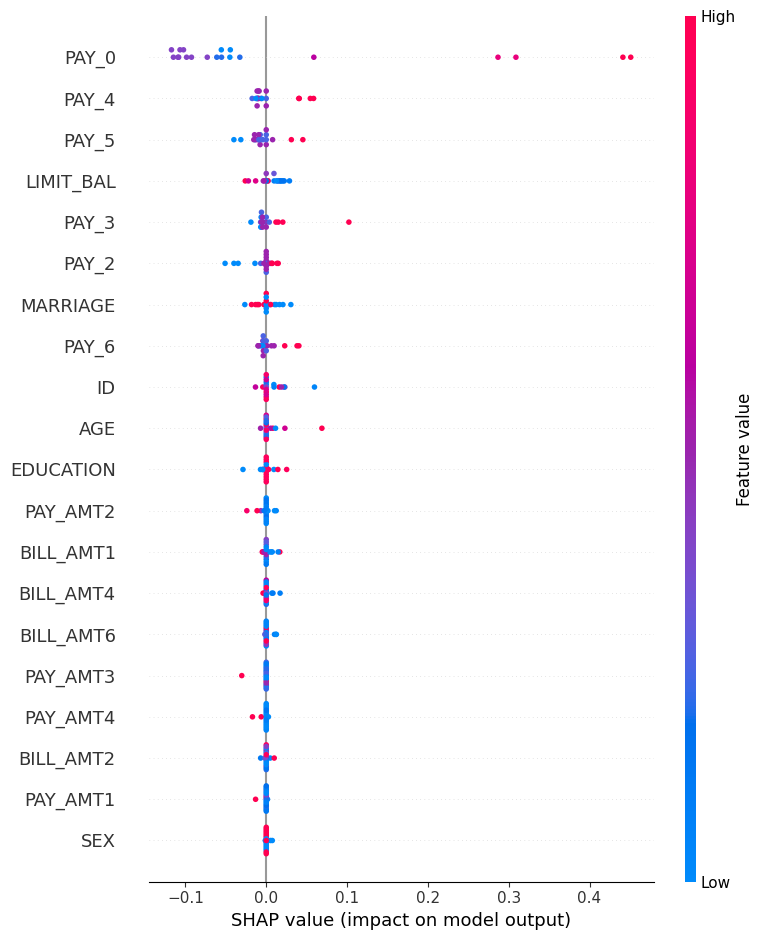

In [ ]:
X_shap_df = pd.DataFrame(
    SHAP_TEST,
    columns=FEATURES
)
shap.summary_plot(
    shap_values,
    X_shap_df,
    show=True
)

In [ ]:
shap_runs = []

for seed in [0, 1]:
    model = TabNetClassifier(
        n_d=16, n_a=16, n_steps=5,
        seed=seed,
        device_name=device,
        verbose=0
    )

    model.fit(
        X_train_s, y_train.values,
        max_epochs=15,
        batch_size=1024,
        virtual_batch_size=128,
        num_workers=0
    )

    def predict_fn(X):
        return model.predict_proba(X)[:, 1]

    expl = shap.KernelExplainer(predict_fn, SHAP_BACKGROUND)
    sv = expl.shap_values(SHAP_TEST)

    assert sv.shape == SHAP_TEST.shape
    shap_runs.append(sv)


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
shap_array = np.stack(shap_runs, axis=0)
print("SHAP array shape:", shap_array.shape)

SHAP array shape: (2, 20, 24)


In [ ]:
# Variance across runs, mean across samples
shap_variance = shap_array.var(axis=0).mean(axis=0)

print("Variance shape:", shap_variance.shape)
print("Features:", len(FEATURES))


Variance shape: (24,)
Features: 24


In [ ]:
stability_df = pd.DataFrame({
    "feature": FEATURES,
    "explanation_variance": shap_variance
}).sort_values("explanation_variance", ascending=False)

stability_df.head(10)

,feature,explanation_variance
6,PAY_0,0.000219
9,PAY_4,0.000107
1,LIMIT_BAL,0.000090
8,PAY_3,0.000090
7,PAY_2,0.000083
5,AGE,0.000038
10,PAY_5,0.000037
13,BILL_AMT2,0.000032
21,PAY_AMT4,0.000031
0,ID,0.000026


In [ ]:
import os

os.getcwd()
os.listdir()


['.config', 'sample_data']